In [1]:
# full-image reconstruction with randomly occluded input

# %% 
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# %matplotlib inline  # uncomment in Jupyter if needed

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------------------
# Paths (aligned with previous notebooks)
# -----------------------------
DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"
CHECKPOINT_DIR = DATA_ROOT / "checkpoints"

print("DATA_ROOT      :", DATA_ROOT)
print("PROCESSED_2D   :", PROCESSED_2D_DIR)
print("INDEX_CSV path :", INDEX_CSV)
print("CHECKPOINT_DIR :", CHECKPOINT_DIR)

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATA_ROOT      : E:\Data\ToothSeg\sts_tooth_data
PROCESSED_2D   : E:\Data\ToothSeg\sts_tooth_data\processed_2d
INDEX_CSV path : E:\Data\ToothSeg\sts_tooth_data\sts2d_index.csv
CHECKPOINT_DIR : E:\Data\ToothSeg\sts_tooth_data\checkpoints
Using device: cuda


In [2]:
# %% [markdown]
# ## 1. Build `df_seg` (image–mask pairs)
#
# The index `sts2d_index.csv` has columns:
# - rel_path
# - age_group
# - label_status
# - is_mask
# - pair_id
#
# We will:
# - separate image rows (is_mask == False) and mask rows (is_mask == True),
# - inner-join them on `pair_id` to obtain only pairs that have both image and mask:
#     -> `df_seg` with ~900 rows.
# %%
assert INDEX_CSV.exists(), f"Index CSV not found: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
print("Full index shape:", df.shape)
print(df.head())

df_img = df[df["is_mask"] == False].copy()
df_mask = df[df["is_mask"] == True].copy()

print("\nNumber of image rows:", len(df_img))
print("Number of mask rows :", len(df_mask))

# Keep only the columns we need from the mask df for joining
df_mask_simple = df_mask[["pair_id", "rel_path"]].rename(columns={"rel_path": "mask_rel"})

# Inner join on pair_id to obtain only (image, mask) pairs
df_seg = pd.merge(df_img, df_mask_simple, on="pair_id", how="inner")

print("\nSegmentation dataframe shape:", df_seg.shape)
print(df_seg.head())

print("\nValue counts — age_group in df_seg:")
print(df_seg["age_group"].value_counts())

print("\nValue counts — label_status in df_seg:")
print(df_seg["label_status"].value_counts())

Full index shape: (4900, 5)
                          rel_path age_group label_status  is_mask  pair_id
0  A-PXI/Labeled/Image/A_L_001.png     adult      labeled    False  a_l_001
1  A-PXI/Labeled/Image/A_L_002.png     adult      labeled    False  a_l_002
2  A-PXI/Labeled/Image/A_L_003.png     adult      labeled    False  a_l_003
3  A-PXI/Labeled/Image/A_L_004.png     adult      labeled    False  a_l_004
4  A-PXI/Labeled/Image/A_L_005.png     adult      labeled    False  a_l_005

Number of image rows: 4000
Number of mask rows : 900

Segmentation dataframe shape: (900, 6)
                          rel_path age_group label_status  is_mask  pair_id  \
0  A-PXI/Labeled/Image/A_L_001.png     adult      labeled    False  a_l_001   
1  A-PXI/Labeled/Image/A_L_002.png     adult      labeled    False  a_l_002   
2  A-PXI/Labeled/Image/A_L_003.png     adult      labeled    False  a_l_003   
3  A-PXI/Labeled/Image/A_L_004.png     adult      labeled    False  a_l_004   
4  A-PXI/Labeled/Image/A_L_

In [3]:
# ## 2. Train/val/test split
#
# We will:
# - Shuffle `df_seg`,
# - Split into:
#     - ~70% train
#     - ~15% val
#     - ~15% test
#
# For simplicity, we perform a random split without explicit stratification.
# (If needed, we could later add stratified splitting based on age_group and label_status.)
# %%
df_seg_shuffled = df_seg.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

n_total = len(df_seg_shuffled)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

df_train = df_seg_shuffled.iloc[:n_train].reset_index(drop=True)
df_val   = df_seg_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True)
df_test  = df_seg_shuffled.iloc[n_train + n_val:].reset_index(drop=True)

print(f"Total samples: {n_total}")
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Total samples: 900
Train: 630, Val: 135, Test: 135


In [4]:
# %% [markdown]
# ## 3. Helper functions for image and mask paths
#
# We convert `rel_path` and `mask_rel` into actual file paths under
# `processed_2d/` using the same convention as in `preprocessing.ipynb`:
#
# - Images:
#     processed_2d / age_group / label_status / "images" / <filename>
# - Masks:
#     processed_2d / age_group / label_status / "masks"  / <filename>
# %%
def get_image_path_from_row(row: pd.Series) -> Path:
    rel = Path(row["rel_path"])
    age_group = row["age_group"]
    label_status = row["label_status"]

    if age_group not in ("adult", "children"):
        age_group = "unknown"
    if label_status not in ("labeled", "unlabeled"):
        label_status = "unknown"

    img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / rel.name
    return img_path


def get_mask_path_from_row(row: pd.Series) -> Path:
    rel = Path(row["mask_rel"])
    age_group = row["age_group"]
    label_status = row["label_status"]

    if age_group not in ("adult", "children"):
        age_group = "unknown"
    if label_status not in ("labeled", "unlabeled"):
        label_status = "unknown"

    mask_path = PROCESSED_2D_DIR / age_group / label_status / "masks" / rel.name
    return mask_path


def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a grayscale numpy array of shape (H, W), dtype uint8.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image file not found: {path}")
    img = Image.open(path).convert("L")  # grayscale
    return np.array(img)


def load_mask_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a mask numpy array of shape (H, W), dtype uint8.
    We will later binarize this mask (foreground vs background).
    """
    if not path.exists():
        raise FileNotFoundError(f"Mask file not found: {path}")
    mask = Image.open(path).convert("L")
    return np.array(mask)


# Quick sanity check
sample_row = df_train.iloc[0]
print("\nSanity check paths:")
print("Image path:", get_image_path_from_row(sample_row))
print("Mask path :", get_mask_path_from_row(sample_row))



Sanity check paths:
Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_071.png
Mask path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\masks\A_L_071.png


In [5]:
# ## 4. Segmentation transforms (Albumentations)
#
# We define:
# - `get_segmentation_train_transform()`:
#     * Resize to (320, 640)
#     * Horizontal flip
#     * Small rotation
#     * Mild brightness/contrast, noise, blur
#     * Normalize (mean=0.5, std=0.25)
#     * Convert to tensor
#
# - `get_segmentation_val_transform()`:
#     * Resize + normalize + tensor
#
# Masks are not normalized by A.Normalize. ToTensorV2 converts them to tensors, 
# and we explicitly binarize with (mask > 0.5) afterward.

# We will binarize them after the transform.
# %%
TARGET_HEIGHT = 320
TARGET_WIDTH = 640

def get_segmentation_train_transform() -> A.Compose:
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.Rotate(
                limit=5,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5,
            ),
            # A.RandomBrightnessContrast(
            #     brightness_limit=0.1,
            #     contrast_limit=0.1,
            #     p=0.5,
            # ),
            # A.GaussNoise(p=0.2),
            # A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            # A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ],
        additional_targets={"mask": "mask"},
    )


def get_segmentation_val_transform() -> A.Compose:
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            # A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ],
        additional_targets={"mask": "mask"},
    )


train_transform = get_segmentation_train_transform()
val_transform = get_segmentation_val_transform()
print("Segmentation transforms created.")

Segmentation transforms created.


In [6]:
# ## 5. `DentalSegmentationDataset`
#
# This Dataset:
# - For each row in df_train/df_val/df_test:
#     * loads grayscale image and mask,
#     * applies Albumentations transform (with consistent transform on image+mask),
#     * binarizes mask to {0,1},
#     * returns `(image_tensor, mask_tensor, meta_dict)`.
# %%
class DentalSegmentationDataset(Dataset):
    def __init__(self, df_seg: pd.DataFrame, transform: A.Compose):
        """
        Args:
            df_seg: DataFrame containing image–mask pairs.
            transform: Albumentations transform (for both image and mask).
        """
        self.df = df_seg.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        mask_path = get_mask_path_from_row(row)

        img_np = load_image_as_array(img_path)   # (H, W), uint8
        mask_np = load_mask_as_array(mask_path)  # (H, W), uint8

        # Albumentations expects dict with "image" and "mask"
        augmented = self.transform(image=img_np, mask=mask_np)
        img_t = augmented["image"]  # FloatTensor, shape (1, H, W)
        mask_t = augmented["mask"]  # FloatTensor, shape (1, H, W) or (H, W)

        # Ensure mask has shape (1, H, W)
        if mask_t.ndim == 2:
            mask_t = mask_t.unsqueeze(0)

        # Binarize mask to {0,1}
        mask_t = (mask_t > 0.5).float()

        meta = {
            "img_path": str(img_path),
            "mask_path": str(mask_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return img_t, mask_t, meta


# Quick sanity check: one sample
train_ds = DentalSegmentationDataset(df_train, transform=train_transform)
img_t, mask_t, meta = train_ds[0]
print("\nSample from train_ds:")
print("Image tensor shape:", img_t.shape)
print("Mask tensor shape :", mask_t.shape)
print("Meta:", meta)



Sample from train_ds:
Image tensor shape: torch.Size([1, 320, 640])
Mask tensor shape : torch.Size([1, 320, 640])
Meta: {'img_path': 'E:\\Data\\ToothSeg\\sts_tooth_data\\processed_2d\\adult\\labeled\\images\\A_L_071.png', 'mask_path': 'E:\\Data\\ToothSeg\\sts_tooth_data\\processed_2d\\adult\\labeled\\masks\\A_L_071.png', 'pair_id': 'a_l_071', 'age_group': 'adult', 'label_status': 'labeled'}


In [7]:
# ## 6. Dataloaders
#
# We create three dataloaders:
# - train_loader
# - val_loader
# - test_loader
#
# Training loader is shuffled, validation/test loaders are not.
# %%
BATCH_SIZE = 4
NUM_WORKERS = 0  # adjust depending on your machine

train_ds = DentalSegmentationDataset(df_train, transform=train_transform)
val_ds   = DentalSegmentationDataset(df_val,   transform=val_transform)
test_ds  = DentalSegmentationDataset(df_test,  transform=val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("Dataloaders ready:")
print("  train batches:", len(train_loader))
print("  val batches  :", len(val_loader))
print("  test batches :", len(test_loader))


Dataloaders ready:
  train batches: 158
  val batches  : 34
  test batches : 34


In [8]:
# ## 7. 2D U-Net model (same as in pretrain_MIM.ipynb)
#
# We reuse the same 2D U-Net architecture:
# - in_channels = 1  (grayscale)
# - out_channels = 1 (binary segmentation logit)
#
# The only difference is the interpretation of the output: here it is a
# per-pixel logit for "tooth" vs "background".
# %%
class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    """Upscaling then DoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: from previous decoder level
        # x2: from encoder skip connection
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2],
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Final 1x1 convolution to produce output channels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, bilinear=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear
        self.base_channels = base_channels

        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 8)

        self.up1 = Up(base_channels * 16, base_channels * 4, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 2, bilinear)
        self.up3 = Up(base_channels * 4, base_channels, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)

        self.outc = OutConv(base_channels, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)
        return logits


model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True)
model = model.to(device)
print(model)


UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [9]:
# ## 8. Load Pretrain weights (optional)
#
# We use the checkpoint from MIM pretraining:
# - `unet2d_mim_pretrained.pth`
#
# Strategy:
# - Build a UNet2D with the same architecture.
# - Load the entire state dict.
# - Optionally re-initialize the final `outc` layer (since the meaning
#   of the output changes from "reconstruction" to "segmentation logit").
#
# By setting `USE_PRETRAINED = False`, you can train a baseline model
# from scratch to compare with the MIM-pretrained initialization.
# %%
USE_PRETRAINED = True  # set to False for a from-scratch baseline

# mim pretrain checkpoint path
# ckpt_path = CHECKPOINT_DIR / "unet2d_mim_pretrained.pth"

# full image pretrain checkpoint path
ckpt_path = CHECKPOINT_DIR / "unet2d_fullimage_pretrained.pth"

if USE_PRETRAINED and ckpt_path.exists():
    state_dict = torch.load(ckpt_path, map_location=device)
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Loaded MIM-pretrained weights from:", ckpt_path)
    print("Missing keys   :", missing)
    print("Unexpected keys:", unexpected)

    # Optionally re-init final output layer for segmentation
    model.outc = OutConv(model.base_channels, 1).to(device)
    print("Reinitialized final output layer (outc) for segmentation.")
else:
    if USE_PRETRAINED:
        print("WARNING: USE_PRETRAINED=True but checkpoint not found, training from scratch.")
    else:
        print("Training from scratch (no pretrained weights loaded).")


Loaded MIM-pretrained weights from: E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_fullimage_pretrained.pth
Missing keys   : []
Unexpected keys: []
Reinitialized final output layer (outc) for segmentation.


In [10]:
# %% [markdown]
# ## 9. Loss functions and metrics
#
# - Loss:
#     * `BCEWithLogitsLoss` + Dice loss
# - Metrics:
#     * Dice coefficient (foreground)
#     * IoU (Jaccard index)
# %%
bce_loss_fn = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    Soft Dice loss computed from logits and target masks in {0,1}.
    Args:
        logits:  (B, 1, H, W)
        targets: (B, 1, H, W) in {0,1}
    """
    probs = torch.sigmoid(logits)
    # Flatten per batch
    probs_flat = probs.view(probs.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (probs_flat * targets_flat).sum(dim=1)
    union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dice = (2.0 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()


def combined_segmentation_loss(logits: torch.Tensor, targets: torch.Tensor, lambda_dice: float = 0.2) -> torch.Tensor:
    """
    Combined loss: BCEWithLogits + lambda_dice * DiceLoss
    """
    loss_bce = bce_loss_fn(logits, targets)
    loss_dice = dice_loss_from_logits(logits, targets)
    return loss_bce + lambda_dice * loss_dice


def compute_dice_score(logits: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, eps: float = 1e-6) -> float:
    """
    Compute foreground Dice coefficient from logits and targets in {0,1}.
    Returns a scalar (mean over batch).
    """
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean().item()


def compute_iou_score(logits: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5, eps: float = 1e-6) -> float:
    """
    Compute IoU (Jaccard index) from logits and targets in {0,1}.
    Returns a scalar (mean over batch).
    """
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [11]:
# ## 10. Optimizer and training hyperparameters
#
# - Optimizer: Adam
# - LR: 1e-4 (smaller than MIM pretraining LR)
# - Epochs: start with 50 as a reasonable number
# - Early stopping: based on validation Dice, with a patience window.
# %%
LR = 5e-5
NUM_EPOCHS = 100
PATIENCE = 10  # epochs without val Dice improvement before early stopping

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Optimizer:", optimizer)


Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0
)


In [12]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from pathlib import Path

# Log path：sts_tooth_data/runs/seg_unet
log_dir = DATA_ROOT / "runs" / "seg_unet"
log_dir.mkdir(parents=True, exist_ok=True)

writer = SummaryWriter(log_dir=str(log_dir))
print("TensorBoard log dir:", log_dir)

TensorBoard log dir: E:\Data\ToothSeg\sts_tooth_data\runs\seg_unet


In [20]:
# ## 11. Fine-tuning loop (with tqdm + TensorBoard)
#
# For each epoch:
# - Train:
#     * forward on train batches
#     * compute combined segmentation loss
#     * backprop + update
# - Validate:
#     * compute loss, Dice, IoU on val set (no gradient)
# - Track:
#     * best validation Dice
#     * save best model checkpoint
# - Early stopping based on val Dice.

from tqdm.auto import tqdm

CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
# best_ckpt_path = CHECKPOINT_DIR / ("unet2d_seg_mim_best.pth" if USE_PRETRAINED else "unet2d_seg_scratch_best.pth")
best_ckpt_path = CHECKPOINT_DIR / ("unet2d_seg_full_image_best.pth" if USE_PRETRAINED else "unet2d_seg_scratch_best.pth")
best_val_dice = 0.0
epochs_without_improvement = 0

global_step = 0 

for epoch in range(1, NUM_EPOCHS + 1):
    # -------------------------
    # Training phase
    
    # -------------------------
    model.train()
    train_loss_sum = 0.0
    train_batches = 0

    # The tqdm progress bar is wrapped in a train_loader layer.
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    for batch in train_pbar:
        imgs, masks, meta = batch
        imgs = imgs.to(device)   # (B, 1, H, W)
        masks = masks.to(device) # (B, 1, H, W)

        optimizer.zero_grad()

        logits = model(imgs)
        loss = combined_segmentation_loss(logits, masks, lambda_dice=0.2)

        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_batches += 1
        global_step += 1

        avg_batch_loss = train_loss_sum / train_batches

        # Update the loss displayed on the progress bar.
        train_pbar.set_postfix({"loss": f"{avg_batch_loss:.4f}"})

        # TensorBoard: Records training loss step by step.
        writer.add_scalar("train/loss_step", loss.item(), global_step)

    avg_train_loss = train_loss_sum / max(1, train_batches)
    writer.add_scalar("train/loss_epoch", avg_train_loss, epoch)

    # -------------------------
    # Validation phase
    # -------------------------
    model.eval()
    val_loss_sum = 0.0
    val_batches = 0
    val_dice_sum = 0.0
    val_iou_sum = 0.0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
        for batch in val_pbar:
            imgs, masks, meta = batch
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = combined_segmentation_loss(logits, masks, lambda_dice=0.2)

            val_loss_sum += loss.item()
            val_batches += 1

            # metrics
            batch_dice = compute_dice_score(logits, masks)
            batch_iou  = compute_iou_score(logits, masks)

            val_dice_sum += batch_dice
            val_iou_sum  += batch_iou

            avg_val_loss_tmp = val_loss_sum / max(1, val_batches)
            avg_val_dice_tmp = val_dice_sum / max(1, val_batches)

            # The verification progress bar displays the current average value loss / die.
            val_pbar.set_postfix({
                "val_loss": f"{avg_val_loss_tmp:.4f}",
                "val_dice": f"{avg_val_dice_tmp:.4f}",
            })

    avg_val_loss = val_loss_sum / max(1, val_batches)
    avg_val_dice = val_dice_sum / max(1, val_batches)
    avg_val_iou  = val_iou_sum  / max(1, val_batches)

    # TensorBoard: Records validation metrics by epoch.
    writer.add_scalar("val/loss", avg_val_loss, epoch)
    writer.add_scalar("val/dice", avg_val_dice, epoch)
    writer.add_scalar("val/iou",  avg_val_iou,  epoch)
    writer.flush()

    print(
        f"Epoch [{epoch:02d}/{NUM_EPOCHS}] "
        f"- Train loss: {avg_train_loss:.4f} "
        f"- Val loss: {avg_val_loss:.4f} "
        f"- Val Dice: {avg_val_dice:.4f} "
        f"- Val IoU: {avg_val_iou:.4f}"
    )

    # -------------------------
    # Check for improvement (by val Dice)
    # -------------------------
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"  -> New best val Dice: {best_val_dice:.4f}. Saved checkpoint to {best_ckpt_path}")
    else:
        epochs_without_improvement += 1
        print(f"  -> No improvement in Dice for {epochs_without_improvement} epoch(s).")

    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

writer.close()


Epoch [01/100] - Train loss: 0.5399 - Val loss: 0.4243 - Val Dice: 0.8935 - Val IoU: 0.8135
  -> New best val Dice: 0.8935. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [02/100] - Train loss: 0.3946 - Val loss: 0.3705 - Val Dice: 0.9106 - Val IoU: 0.8420
  -> New best val Dice: 0.9106. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [03/100] - Train loss: 0.3486 - Val loss: 0.3240 - Val Dice: 0.9094 - Val IoU: 0.8402
  -> No improvement in Dice for 1 epoch(s).


Epoch [04/100] - Train loss: 0.3125 - Val loss: 0.2999 - Val Dice: 0.9121 - Val IoU: 0.8443
  -> New best val Dice: 0.9121. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [05/100] - Train loss: 0.2876 - Val loss: 0.2773 - Val Dice: 0.9195 - Val IoU: 0.8571
  -> New best val Dice: 0.9195. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [06/100] - Train loss: 0.2654 - Val loss: 0.2560 - Val Dice: 0.9194 - Val IoU: 0.8569
  -> No improvement in Dice for 1 epoch(s).


Epoch [07/100] - Train loss: 0.2461 - Val loss: 0.2339 - Val Dice: 0.9232 - Val IoU: 0.8635
  -> New best val Dice: 0.9232. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [08/100] - Train loss: 0.2275 - Val loss: 0.2189 - Val Dice: 0.9258 - Val IoU: 0.8683
  -> New best val Dice: 0.9258. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [09/100] - Train loss: 0.2115 - Val loss: 0.2050 - Val Dice: 0.9228 - Val IoU: 0.8627
  -> No improvement in Dice for 1 epoch(s).


Epoch [10/100] - Train loss: 0.1979 - Val loss: 0.1901 - Val Dice: 0.9259 - Val IoU: 0.8686
  -> New best val Dice: 0.9259. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [11/100] - Train loss: 0.1844 - Val loss: 0.1779 - Val Dice: 0.9271 - Val IoU: 0.8704
  -> New best val Dice: 0.9271. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [12/100] - Train loss: 0.1728 - Val loss: 0.1676 - Val Dice: 0.9275 - Val IoU: 0.8711
  -> New best val Dice: 0.9275. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [13/100] - Train loss: 0.1627 - Val loss: 0.1582 - Val Dice: 0.9283 - Val IoU: 0.8724
  -> New best val Dice: 0.9283. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [14/100] - Train loss: 0.1542 - Val loss: 0.1513 - Val Dice: 0.9224 - Val IoU: 0.8621
  -> No improvement in Dice for 1 epoch(s).


Epoch [15/100] - Train loss: 0.1459 - Val loss: 0.1406 - Val Dice: 0.9299 - Val IoU: 0.8752
  -> New best val Dice: 0.9299. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [16/100] - Train loss: 0.1373 - Val loss: 0.1347 - Val Dice: 0.9290 - Val IoU: 0.8736
  -> No improvement in Dice for 1 epoch(s).


Epoch [17/100] - Train loss: 0.1307 - Val loss: 0.1298 - Val Dice: 0.9321 - Val IoU: 0.8797
  -> New best val Dice: 0.9321. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [18/100] - Train loss: 0.1256 - Val loss: 0.1232 - Val Dice: 0.9316 - Val IoU: 0.8785
  -> No improvement in Dice for 1 epoch(s).


Epoch [19/100] - Train loss: 0.1192 - Val loss: 0.1219 - Val Dice: 0.9265 - Val IoU: 0.8691
  -> No improvement in Dice for 2 epoch(s).


Epoch [20/100] - Train loss: 0.1147 - Val loss: 0.1125 - Val Dice: 0.9323 - Val IoU: 0.8799
  -> New best val Dice: 0.9323. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [21/100] - Train loss: 0.1097 - Val loss: 0.1095 - Val Dice: 0.9317 - Val IoU: 0.8787
  -> No improvement in Dice for 1 epoch(s).


Epoch [22/100] - Train loss: 0.1060 - Val loss: 0.1042 - Val Dice: 0.9330 - Val IoU: 0.8813
  -> New best val Dice: 0.9330. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [23/100] - Train loss: 0.1025 - Val loss: 0.1003 - Val Dice: 0.9338 - Val IoU: 0.8829
  -> New best val Dice: 0.9338. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [24/100] - Train loss: 0.0993 - Val loss: 0.0989 - Val Dice: 0.9338 - Val IoU: 0.8827
  -> No improvement in Dice for 1 epoch(s).


Epoch [25/100] - Train loss: 0.0959 - Val loss: 0.0968 - Val Dice: 0.9326 - Val IoU: 0.8800
  -> No improvement in Dice for 2 epoch(s).


Epoch [26/100] - Train loss: 0.0924 - Val loss: 0.0925 - Val Dice: 0.9342 - Val IoU: 0.8832
  -> New best val Dice: 0.9342. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [27/100] - Train loss: 0.0908 - Val loss: 0.0913 - Val Dice: 0.9340 - Val IoU: 0.8827
  -> No improvement in Dice for 1 epoch(s).


Epoch [28/100] - Train loss: 0.0872 - Val loss: 0.0893 - Val Dice: 0.9342 - Val IoU: 0.8835
  -> New best val Dice: 0.9342. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [29/100] - Train loss: 0.0860 - Val loss: 0.0891 - Val Dice: 0.9334 - Val IoU: 0.8817
  -> No improvement in Dice for 1 epoch(s).


Epoch [30/100] - Train loss: 0.0833 - Val loss: 0.0908 - Val Dice: 0.9303 - Val IoU: 0.8759
  -> No improvement in Dice for 2 epoch(s).


Epoch [31/100] - Train loss: 0.0821 - Val loss: 0.0878 - Val Dice: 0.9315 - Val IoU: 0.8794
  -> No improvement in Dice for 3 epoch(s).


Epoch [32/100] - Train loss: 0.0808 - Val loss: 0.0837 - Val Dice: 0.9348 - Val IoU: 0.8845
  -> New best val Dice: 0.9348. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [33/100] - Train loss: 0.0790 - Val loss: 0.0834 - Val Dice: 0.9335 - Val IoU: 0.8828
  -> No improvement in Dice for 1 epoch(s).


Epoch [34/100] - Train loss: 0.0769 - Val loss: 0.0826 - Val Dice: 0.9339 - Val IoU: 0.8828
  -> No improvement in Dice for 2 epoch(s).


Epoch [35/100] - Train loss: 0.0760 - Val loss: 0.0810 - Val Dice: 0.9347 - Val IoU: 0.8841
  -> No improvement in Dice for 3 epoch(s).


Epoch [36/100] - Train loss: 0.0741 - Val loss: 0.0842 - Val Dice: 0.9312 - Val IoU: 0.8775
  -> No improvement in Dice for 4 epoch(s).


Epoch [37/100] - Train loss: 0.0734 - Val loss: 0.0811 - Val Dice: 0.9338 - Val IoU: 0.8822
  -> No improvement in Dice for 5 epoch(s).


Epoch [38/100] - Train loss: 0.0717 - Val loss: 0.0787 - Val Dice: 0.9357 - Val IoU: 0.8863
  -> New best val Dice: 0.9357. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [39/100] - Train loss: 0.0703 - Val loss: 0.0788 - Val Dice: 0.9349 - Val IoU: 0.8849
  -> No improvement in Dice for 1 epoch(s).


Epoch [40/100] - Train loss: 0.0697 - Val loss: 0.0834 - Val Dice: 0.9306 - Val IoU: 0.8764
  -> No improvement in Dice for 2 epoch(s).


Epoch [41/100] - Train loss: 0.0697 - Val loss: 0.0800 - Val Dice: 0.9333 - Val IoU: 0.8814
  -> No improvement in Dice for 3 epoch(s).


Epoch [42/100] - Train loss: 0.0686 - Val loss: 0.0763 - Val Dice: 0.9361 - Val IoU: 0.8867
  -> New best val Dice: 0.9361. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [43/100] - Train loss: 0.0672 - Val loss: 0.0768 - Val Dice: 0.9353 - Val IoU: 0.8853
  -> No improvement in Dice for 1 epoch(s).


Epoch [44/100] - Train loss: 0.0651 - Val loss: 0.0759 - Val Dice: 0.9367 - Val IoU: 0.8883
  -> New best val Dice: 0.9367. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [45/100] - Train loss: 0.0659 - Val loss: 0.0750 - Val Dice: 0.9368 - Val IoU: 0.8882
  -> New best val Dice: 0.9368. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [46/100] - Train loss: 0.0652 - Val loss: 0.0825 - Val Dice: 0.9291 - Val IoU: 0.8737
  -> No improvement in Dice for 1 epoch(s).


Epoch [47/100] - Train loss: 0.0645 - Val loss: 0.0786 - Val Dice: 0.9319 - Val IoU: 0.8788
  -> No improvement in Dice for 2 epoch(s).


Epoch [48/100] - Train loss: 0.0632 - Val loss: 0.0747 - Val Dice: 0.9361 - Val IoU: 0.8866
  -> No improvement in Dice for 3 epoch(s).


Epoch [49/100] - Train loss: 0.0626 - Val loss: 0.0746 - Val Dice: 0.9354 - Val IoU: 0.8853
  -> No improvement in Dice for 4 epoch(s).


Epoch [50/100] - Train loss: 0.0620 - Val loss: 0.0740 - Val Dice: 0.9362 - Val IoU: 0.8872
  -> No improvement in Dice for 5 epoch(s).


Epoch [51/100] - Train loss: 0.0616 - Val loss: 0.0739 - Val Dice: 0.9361 - Val IoU: 0.8865
  -> No improvement in Dice for 6 epoch(s).


Epoch [52/100] - Train loss: 0.0598 - Val loss: 0.0740 - Val Dice: 0.9380 - Val IoU: 0.8903
  -> New best val Dice: 0.9380. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [53/100] - Train loss: 0.0607 - Val loss: 0.0729 - Val Dice: 0.9378 - Val IoU: 0.8902
  -> No improvement in Dice for 1 epoch(s).


Epoch [54/100] - Train loss: 0.0597 - Val loss: 0.0732 - Val Dice: 0.9371 - Val IoU: 0.8889
  -> No improvement in Dice for 2 epoch(s).


Epoch [55/100] - Train loss: 0.0590 - Val loss: 0.0729 - Val Dice: 0.9382 - Val IoU: 0.8907
  -> New best val Dice: 0.9382. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [56/100] - Train loss: 0.0588 - Val loss: 0.0770 - Val Dice: 0.9324 - Val IoU: 0.8798
  -> No improvement in Dice for 1 epoch(s).


Epoch [57/100] - Train loss: 0.0585 - Val loss: 0.0752 - Val Dice: 0.9353 - Val IoU: 0.8850
  -> No improvement in Dice for 2 epoch(s).


Epoch [58/100] - Train loss: 0.0572 - Val loss: 0.0736 - Val Dice: 0.9385 - Val IoU: 0.8916
  -> New best val Dice: 0.9385. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [59/100] - Train loss: 0.0571 - Val loss: 0.0719 - Val Dice: 0.9376 - Val IoU: 0.8891
  -> No improvement in Dice for 1 epoch(s).


Epoch [60/100] - Train loss: 0.0572 - Val loss: 0.0709 - Val Dice: 0.9386 - Val IoU: 0.8915
  -> New best val Dice: 0.9386. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [61/100] - Train loss: 0.0561 - Val loss: 0.0713 - Val Dice: 0.9396 - Val IoU: 0.8932
  -> New best val Dice: 0.9396. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [62/100] - Train loss: 0.0556 - Val loss: 0.0701 - Val Dice: 0.9403 - Val IoU: 0.8945
  -> New best val Dice: 0.9403. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [63/100] - Train loss: 0.0550 - Val loss: 0.0726 - Val Dice: 0.9383 - Val IoU: 0.8908
  -> No improvement in Dice for 1 epoch(s).


Epoch [64/100] - Train loss: 0.0556 - Val loss: 0.0703 - Val Dice: 0.9387 - Val IoU: 0.8914
  -> No improvement in Dice for 2 epoch(s).


Epoch [65/100] - Train loss: 0.0543 - Val loss: 0.0700 - Val Dice: 0.9402 - Val IoU: 0.8943
  -> No improvement in Dice for 3 epoch(s).


Epoch [66/100] - Train loss: 0.0545 - Val loss: 0.0720 - Val Dice: 0.9399 - Val IoU: 0.8938
  -> No improvement in Dice for 4 epoch(s).


Epoch [67/100] - Train loss: 0.0537 - Val loss: 0.0708 - Val Dice: 0.9402 - Val IoU: 0.8944
  -> No improvement in Dice for 5 epoch(s).


Epoch [68/100] - Train loss: 0.0544 - Val loss: 0.0707 - Val Dice: 0.9395 - Val IoU: 0.8929
  -> No improvement in Dice for 6 epoch(s).


Epoch [69/100] - Train loss: 0.0535 - Val loss: 0.0707 - Val Dice: 0.9394 - Val IoU: 0.8927
  -> No improvement in Dice for 7 epoch(s).


Epoch [70/100] - Train loss: 0.0519 - Val loss: 0.0705 - Val Dice: 0.9401 - Val IoU: 0.8942
  -> No improvement in Dice for 8 epoch(s).


Epoch [71/100] - Train loss: 0.0525 - Val loss: 0.0710 - Val Dice: 0.9402 - Val IoU: 0.8942
  -> No improvement in Dice for 9 epoch(s).


Epoch [72/100] - Train loss: 0.0517 - Val loss: 0.0717 - Val Dice: 0.9404 - Val IoU: 0.8949
  -> New best val Dice: 0.9404. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [73/100] - Train loss: 0.0529 - Val loss: 0.0707 - Val Dice: 0.9389 - Val IoU: 0.8917
  -> No improvement in Dice for 1 epoch(s).


Epoch [74/100] - Train loss: 0.0524 - Val loss: 0.0703 - Val Dice: 0.9409 - Val IoU: 0.8955
  -> New best val Dice: 0.9409. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [75/100] - Train loss: 0.0512 - Val loss: 0.0717 - Val Dice: 0.9406 - Val IoU: 0.8954
  -> No improvement in Dice for 1 epoch(s).


Epoch [76/100] - Train loss: 0.0515 - Val loss: 0.0714 - Val Dice: 0.9393 - Val IoU: 0.8925
  -> No improvement in Dice for 2 epoch(s).


Epoch [77/100] - Train loss: 0.0505 - Val loss: 0.0709 - Val Dice: 0.9417 - Val IoU: 0.8972
  -> New best val Dice: 0.9417. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [78/100] - Train loss: 0.0503 - Val loss: 0.0723 - Val Dice: 0.9386 - Val IoU: 0.8915
  -> No improvement in Dice for 1 epoch(s).


Epoch [79/100] - Train loss: 0.0508 - Val loss: 0.0713 - Val Dice: 0.9408 - Val IoU: 0.8957
  -> No improvement in Dice for 2 epoch(s).


Epoch [80/100] - Train loss: 0.0497 - Val loss: 0.0703 - Val Dice: 0.9417 - Val IoU: 0.8972
  -> New best val Dice: 0.9417. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [81/100] - Train loss: 0.0486 - Val loss: 0.0751 - Val Dice: 0.9404 - Val IoU: 0.8951
  -> No improvement in Dice for 1 epoch(s).


Epoch [82/100] - Train loss: 0.0488 - Val loss: 0.0733 - Val Dice: 0.9403 - Val IoU: 0.8950
  -> No improvement in Dice for 2 epoch(s).


Epoch [83/100] - Train loss: 0.0495 - Val loss: 0.0705 - Val Dice: 0.9409 - Val IoU: 0.8955
  -> No improvement in Dice for 3 epoch(s).


Epoch [84/100] - Train loss: 0.0488 - Val loss: 0.0735 - Val Dice: 0.9409 - Val IoU: 0.8958
  -> No improvement in Dice for 4 epoch(s).


Epoch [85/100] - Train loss: 0.0500 - Val loss: 0.0720 - Val Dice: 0.9413 - Val IoU: 0.8965
  -> No improvement in Dice for 5 epoch(s).


Epoch [86/100] - Train loss: 0.0496 - Val loss: 0.0695 - Val Dice: 0.9421 - Val IoU: 0.8979
  -> New best val Dice: 0.9421. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [87/100] - Train loss: 0.0483 - Val loss: 0.0770 - Val Dice: 0.9400 - Val IoU: 0.8946
  -> No improvement in Dice for 1 epoch(s).


Epoch [88/100] - Train loss: 0.0476 - Val loss: 0.0702 - Val Dice: 0.9408 - Val IoU: 0.8954
  -> No improvement in Dice for 2 epoch(s).


Epoch [89/100] - Train loss: 0.0489 - Val loss: 0.0697 - Val Dice: 0.9414 - Val IoU: 0.8965
  -> No improvement in Dice for 3 epoch(s).


Epoch [90/100] - Train loss: 0.0484 - Val loss: 0.0713 - Val Dice: 0.9399 - Val IoU: 0.8937
  -> No improvement in Dice for 4 epoch(s).


Epoch [91/100] - Train loss: 0.0480 - Val loss: 0.0706 - Val Dice: 0.9412 - Val IoU: 0.8960
  -> No improvement in Dice for 5 epoch(s).


Epoch [92/100] - Train loss: 0.0473 - Val loss: 0.0711 - Val Dice: 0.9418 - Val IoU: 0.8975
  -> No improvement in Dice for 6 epoch(s).


Epoch [93/100] - Train loss: 0.0482 - Val loss: 0.0727 - Val Dice: 0.9406 - Val IoU: 0.8955
  -> No improvement in Dice for 7 epoch(s).


Epoch [94/100] - Train loss: 0.0479 - Val loss: 0.0700 - Val Dice: 0.9417 - Val IoU: 0.8974
  -> No improvement in Dice for 8 epoch(s).


Epoch [95/100] - Train loss: 0.0471 - Val loss: 0.0687 - Val Dice: 0.9421 - Val IoU: 0.8978
  -> New best val Dice: 0.9421. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [96/100] - Train loss: 0.0469 - Val loss: 0.0711 - Val Dice: 0.9425 - Val IoU: 0.8988
  -> New best val Dice: 0.9425. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [97/100] - Train loss: 0.0468 - Val loss: 0.0696 - Val Dice: 0.9432 - Val IoU: 0.8998
  -> New best val Dice: 0.9432. Saved checkpoint to E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth


Epoch [98/100] - Train loss: 0.0461 - Val loss: 0.0729 - Val Dice: 0.9423 - Val IoU: 0.8984
  -> No improvement in Dice for 1 epoch(s).


Epoch [99/100] - Train loss: 0.0468 - Val loss: 0.0742 - Val Dice: 0.9397 - Val IoU: 0.8940
  -> No improvement in Dice for 2 epoch(s).


Epoch [100/100] - Train loss: 0.0462 - Val loss: 0.0724 - Val Dice: 0.9415 - Val IoU: 0.8968
  -> No improvement in Dice for 3 epoch(s).


In [13]:
# %% [markdown]
# ## 12. Evaluation on test set (using best checkpoint)
#
# We load the best checkpoint (according to validation Dice)
# and evaluate on the held-out test set:
# - Test loss
# - Test Dice
# - Test IoU
# %%

# Load best model for mim image training
# best_ckpt_path = CHECKPOINT_DIR / ("unet2d_seg_mim_best.pth" if USE_PRETRAINED else "unet2d_seg_scratch_best.pth")

# Load best model for full image training
best_ckpt_path = CHECKPOINT_DIR / ("unet2d_seg_full_image_best.pth" if USE_PRETRAINED else "unet2d_seg_scratch_best.pth")

if best_ckpt_path.exists():
    state_dict = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Loaded best segmentation checkpoint from:", best_ckpt_path)
else:
    print("WARNING: Best checkpoint not found, using current model weights.")

model.eval()

test_loss_sum = 0.0
test_batches = 0
test_dice_sum = 0.0
test_iou_sum = 0.0

with torch.no_grad():
    for batch in test_loader:
        imgs, masks, meta = batch
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        loss = combined_segmentation_loss(logits, masks, lambda_dice=0.2)
        test_loss_sum += loss.item()
        test_batches += 1

        batch_dice = compute_dice_score(logits, masks)
        batch_iou  = compute_iou_score(logits, masks)

        test_dice_sum += batch_dice
        test_iou_sum  += batch_iou

avg_test_loss = test_loss_sum / max(1, test_batches)
avg_test_dice = test_dice_sum / max(1, test_batches)
avg_test_iou  = test_iou_sum  / max(1, test_batches)

print("\n=== Test set evaluation ===")
print(f"Test loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")
print(f"Test IoU : {avg_test_iou:.4f}")


Loaded best segmentation checkpoint from: E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_seg_full_image_best.pth

=== Test set evaluation ===
Test loss: 0.0926
Test Dice: 0.9309
Test IoU : 0.8786


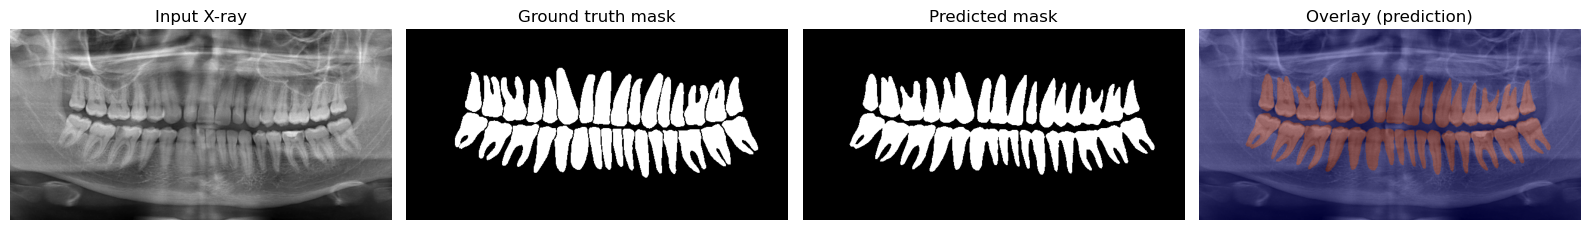

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_201.png


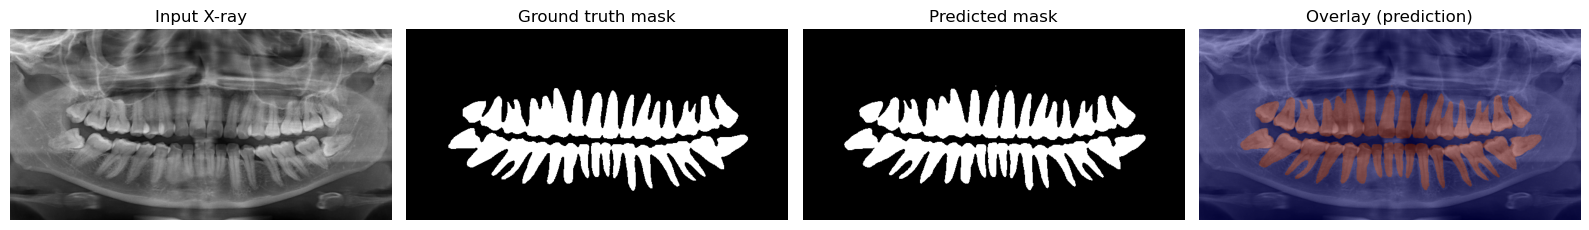

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_135.png


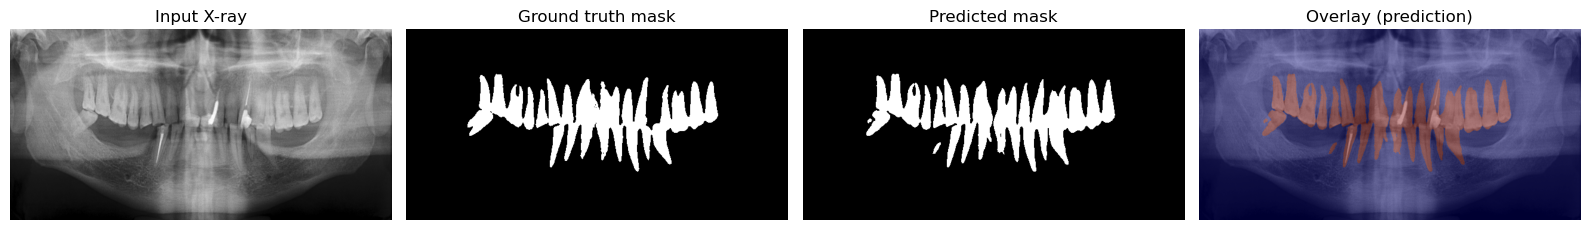

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_028.png


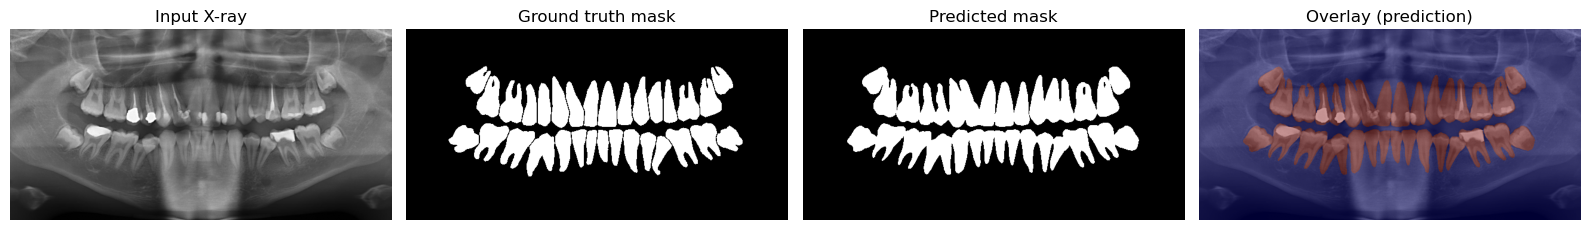

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_789.png


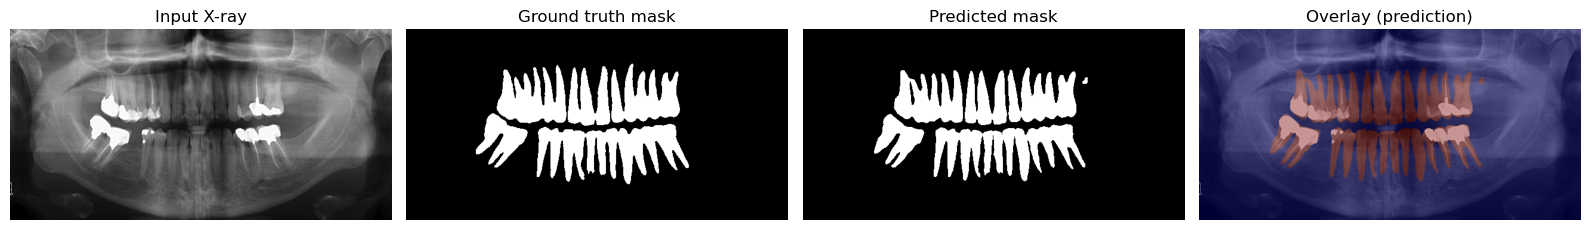

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_231.png


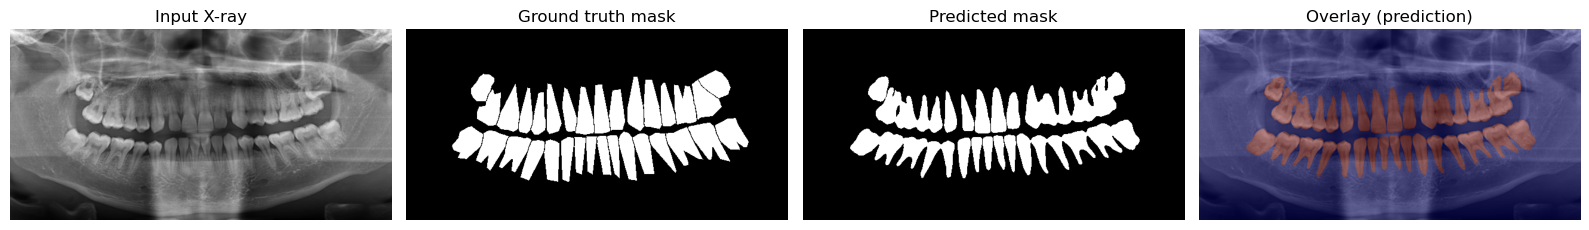

Image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_490.png


In [14]:
# ## 13. Qualitative visualization (optional)
#
# We visualize a few samples from the test set:
# - Input X-ray
# - Ground truth mask
# - Predicted mask (thresholded at 0.5)
# - Overlay
# %%
NUM_VIS_SAMPLES = 6

model.eval()
with torch.no_grad():
    count = 0
    for imgs, masks, meta in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()

        for b in range(imgs.size(0)):
            if count >= NUM_VIS_SAMPLES:
                break

            img_np   = imgs[b].cpu().squeeze(0).numpy()
            gt_np    = masks[b].cpu().squeeze(0).numpy()
            pred_np  = preds[b].cpu().squeeze(0).numpy()

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(img_np, cmap="gray")
            axes[0].set_title("Input X-ray")
            axes[0].axis("off")

            axes[1].imshow(gt_np, cmap="gray")
            axes[1].set_title("Ground truth mask")
            axes[1].axis("off")

            axes[2].imshow(pred_np, cmap="gray")
            axes[2].set_title("Predicted mask")
            axes[2].axis("off")

            # Overlay prediction on input
            axes[3].imshow(img_np, cmap="gray")
            axes[3].imshow(pred_np, alpha=0.4, cmap="jet")
            axes[3].set_title("Overlay (prediction)")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

            print("Image path:", meta["img_path"][b])
            count += 1

        if count >= NUM_VIS_SAMPLES:
            break

In [103]:
images, masks, metas = next(iter(train_loader))

print("images shape:", images.shape)
print("images dtype:", images.dtype)
print("images range:", images.min().item(), "->", images.max().item())

print("masks shape:", masks.shape)
print("masks dtype:", masks.dtype)
print("masks unique:", masks.unique())

print("metas type:", type(metas))
print("metas keys:", metas.keys() if isinstance(metas, dict) else None)


images shape: torch.Size([4, 1, 320, 640])
images dtype: torch.float32
images range: -1.9843138456344604 -> 2.0
masks shape: torch.Size([4, 1, 320, 640])
masks dtype: torch.float32
masks unique: tensor([0., 1.])
metas type: <class 'dict'>
metas keys: dict_keys(['img_path', 'mask_path', 'pair_id', 'age_group', 'label_status'])


In [ ]:
!tensorboard --logdir sts_tooth_data/runs